In [2]:
pip install pandas matplotlib seaborn dash plotly

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------------------------------ --------- 6.0/7.8 MB 37.0 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 32.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [93]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [95]:
import pandas as pd

# Load the dataset
df = pd.read_csv('data_gov_lse_rexus.csv',  on_bad_lines='skip')

# Display the first few rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7583 entries, 0 to 7582
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Lease Number                   7583 non-null   object 
 1   Current Expiration Date        7583 non-null   object 
 2   Lease Initial Effective Date   7583 non-null   object 
 3   Location Code                  7583 non-null   object 
 4   Lease ANSI Rentable Sqft       7583 non-null   float64
 5   Lease Usable Sqft              7583 non-null   float64
 6   Lse Structured Parking Spaces  7583 non-null   int64  
 7   Lse Surface Parking Spaces     7583 non-null   int64  
 8   Lease Annual Rent Amount       7583 non-null   float64
 9   Lease Responsibility           7583 non-null   object 
 10  Lessor Name                    7583 non-null   object 
 11  Lessor In-Care-Of              7580 non-null   object 
 12  Lessor Address 1               7583 non-null   o

In [97]:
# Example: Convert 'lease_start_date' to datetime
df['Current Expiration Date'] = pd.to_datetime(df['Current Expiration Date'])
df['Lease Initial Effective Date'] = pd.to_datetime(df['Lease Initial Effective Date'])

In [99]:
df['lease_duration_days'] = (df['Current Expiration Date'] - df['Lease Initial Effective Date']).dt.days

In [103]:
# Handle missing values
df['Lessor In-Care-Of'].fillna('Unknown', inplace=True)
df['Lessor Address 2'].fillna('', inplace=True)

# Save cleaned data
df.to_csv('cleaned_lease_data.csv', index=False)

In [105]:
print(df[['Current Expiration Date', 'Lease Initial Effective Date']].isnull().sum())
# Convert relevant float columns to integer
df['Lease ANSI Rentable Sqft'] = df['Lease ANSI Rentable Sqft'].astype(int)
df['Lease Usable Sqft'] = df['Lease Usable Sqft'].astype(int)
df['Lease Annual Rent Amount'] = df['Lease Annual Rent Amount'].astype(int)

Current Expiration Date         0
Lease Initial Effective Date    0
dtype: int64


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7583 entries, 0 to 7582
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Lease Number                   7583 non-null   object        
 1   Current Expiration Date        7583 non-null   datetime64[ns]
 2   Lease Initial Effective Date   7583 non-null   datetime64[ns]
 3   Location Code                  7583 non-null   object        
 4   Lease ANSI Rentable Sqft       7583 non-null   int32         
 5   Lease Usable Sqft              7583 non-null   int32         
 6   Lse Structured Parking Spaces  7583 non-null   int64         
 7   Lse Surface Parking Spaces     7583 non-null   int64         
 8   Lease Annual Rent Amount       7583 non-null   int32         
 9   Lease Responsibility           7583 non-null   object        
 10  Lessor Name                    7583 non-null   object        
 11  Lessor In-Care-Of

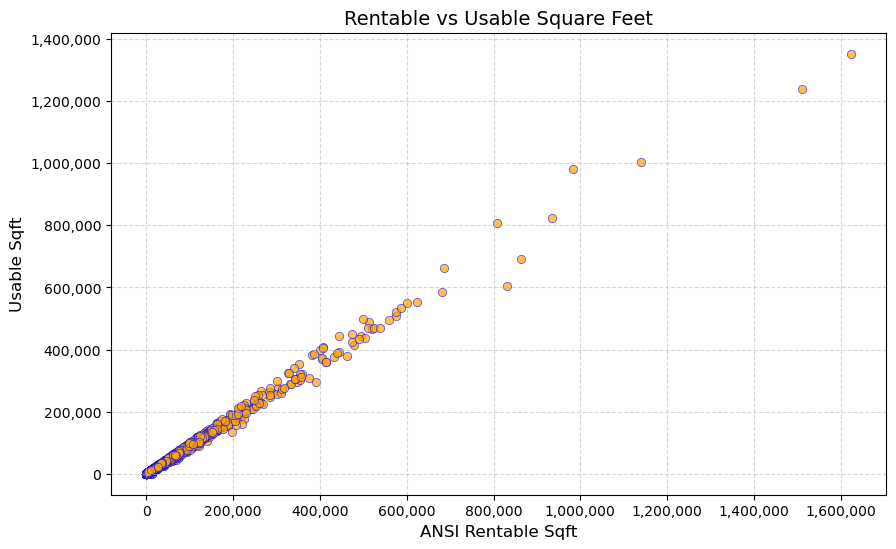

In [111]:
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatterplot with custom colors
sns.scatterplot(
    x='Lease ANSI Rentable Sqft', 
    y='Lease Usable Sqft', 
    data=df, 
    alpha=0.7, 
    color='orange',  # Set orange color
    edgecolor='blue',  # Blue edge for the markers
    linewidth=0.5
)

plt.title('Rentable vs Usable Square Feet', fontsize=14)
plt.xlabel('ANSI Rentable Sqft', fontsize=12)
plt.ylabel('Usable Sqft', fontsize=12)

# Set the formatter for the x and y axes to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):,}'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


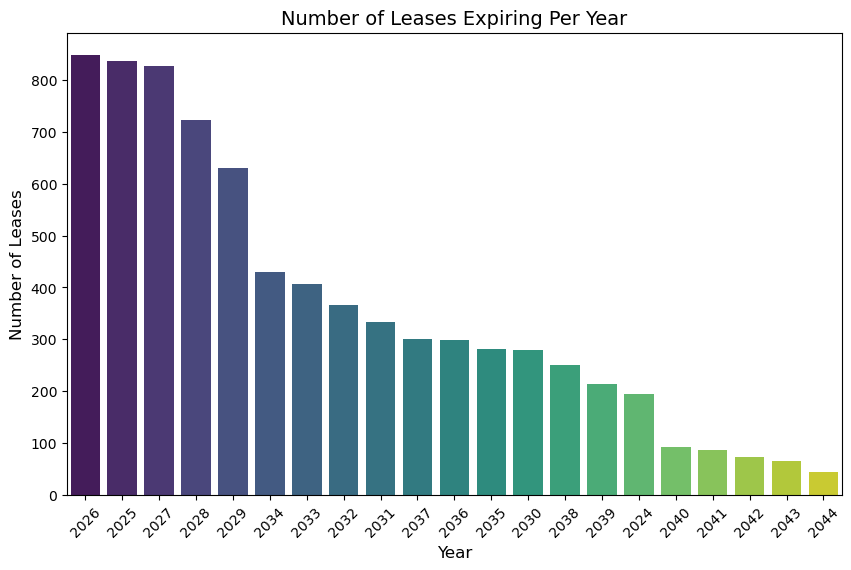

In [123]:
df['Expiration Year'] = df['Current Expiration Date'].dt.year

# Calculate the count of leases expiring per year and sort in descending order
expiration_counts = df['Expiration Year'].value_counts().sort_values(ascending=False)

# Reorder the categories in the data based on the sorted counts
df['Expiration Year'] = pd.Categorical(df['Expiration Year'], categories=expiration_counts.index, ordered=True)

# Plot the countplot with reordered bars
plt.figure(figsize=(10, 6))
sns.countplot(x='Expiration Year', data=df, palette='viridis', order=expiration_counts.index)
plt.title('Number of Leases Expiring Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Leases', fontsize=12)
plt.xticks(rotation=45)
plt.show()

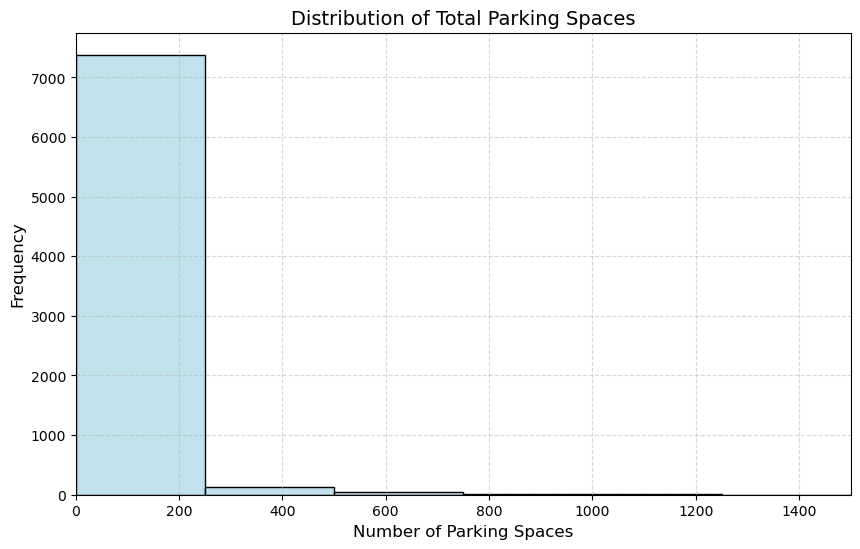

In [119]:
# Total parking spaces
df['Total Parking Spaces'] = df['Lse Structured Parking Spaces'] + df['Lse Surface Parking Spaces']

plt.figure(figsize=(10, 6))
sns.histplot(df['Total Parking Spaces'], kde=False, bins=20, color='lightblue')
plt.title('Distribution of Total Parking Spaces', fontsize=14)
plt.xlabel('Number of Parking Spaces', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set x-axis limit to 2000
plt.xlim(0, 1500)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

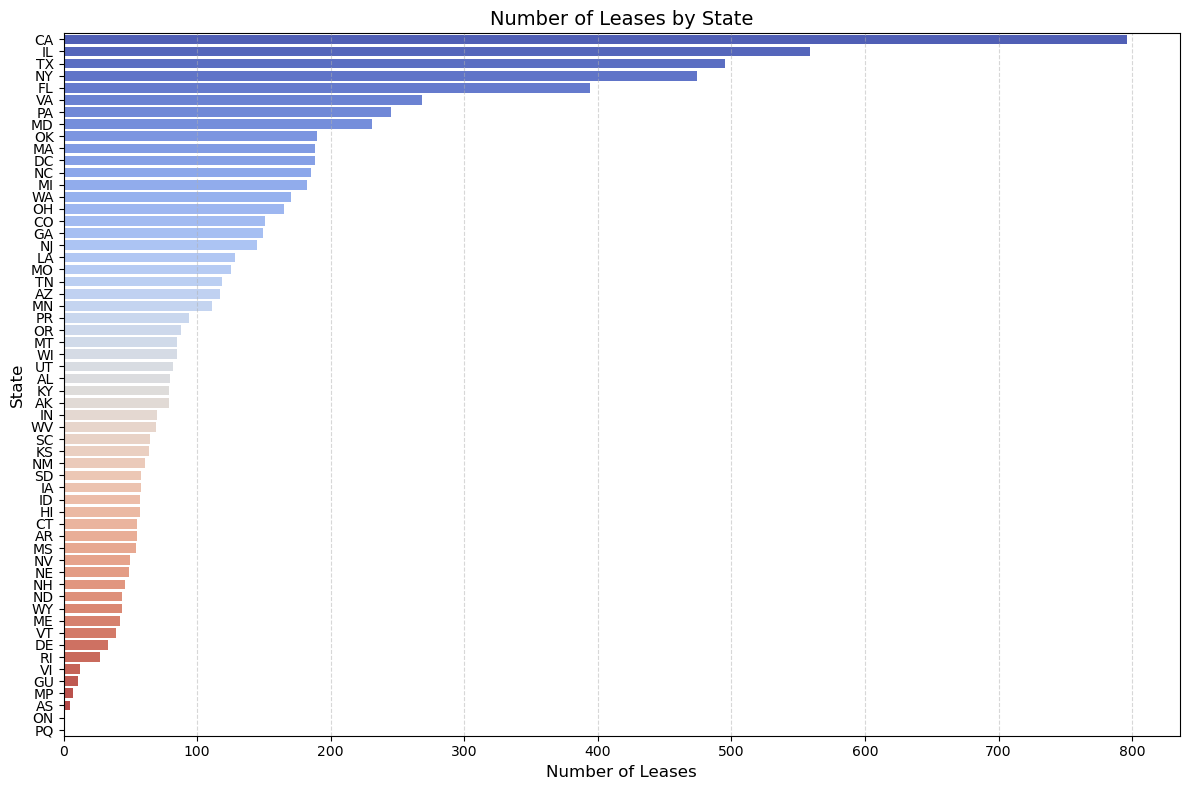

In [121]:
# Standardize the state names
df['Lessor State'] = df['Lessor State'].replace({'Illinois': 'IL'})

# Remove blank states
df = df[df['Lessor State'].str.strip() != ""]

# Plot the graph again
plt.figure(figsize=(12, 8))

# Use a horizontal bar chart for better readability
sns.barplot(
    x=df['Lessor State'].value_counts().values, 
    y=df['Lessor State'].value_counts().index, 
    palette='coolwarm'
)

plt.title('Number of Leases by State', fontsize=14)
plt.xlabel('Number of Leases', fontsize=12)
plt.ylabel('State', fontsize=12)

# Adjust the size of y-axis labels for better spacing
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [127]:
df.to_csv('cleaned_lease_data.csv', index=False)